# Importing modules

In [1]:
import glob
import cv2
import PIL
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,TensorBoard

# Pre-processing

In [13]:
def process(filename, key, dest):
    image = cv2.imread(filename)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (7,7), 0)
    canny = cv2.Canny(blurred_image, 10, 30)
    cv2.imwrite( dest+'\imageresized_{}.jpeg'.format(key) ,canny )

In [16]:
d1 = ["test","train"]
d2 = ["NORMAL","PNEUMONIA"]

In [18]:
for i in range(2):
    for j in range(2):
        tt = d1[i]+"\\"+d2[j]
        t1 = "D:\\Users\\Desktop\\Sem V\\DL\\DL-projects\\mini project\\chest_xray\\"+tt
        t2 = "D:\\Users\\Desktop\\Sem V\\DL\\DL-projects\\mini project\\DL_Dataset\\"+tt
        print(t1+"\n"+t2)
        for (k,image_file) in enumerate(glob.iglob(t1+'/*.jpeg')):
            process(image_file, k,t2)
        print("Done!")

D:\Users\Desktop\Sem V\DL\DL-projects\mini project\chest_xray\test\NORMAL
D:\Users\Desktop\Sem V\DL\DL-projects\mini project\DL_Dataset\test\NORMAL
Done!
D:\Users\Desktop\Sem V\DL\DL-projects\mini project\chest_xray\test\PNEUMONIA
D:\Users\Desktop\Sem V\DL\DL-projects\mini project\DL_Dataset\test\PNEUMONIA
Done!
D:\Users\Desktop\Sem V\DL\DL-projects\mini project\chest_xray\train\NORMAL
D:\Users\Desktop\Sem V\DL\DL-projects\mini project\DL_Dataset\train\NORMAL
Done!
D:\Users\Desktop\Sem V\DL\DL-projects\mini project\chest_xray\train\PNEUMONIA
D:\Users\Desktop\Sem V\DL\DL-projects\mini project\DL_Dataset\train\PNEUMONIA
Done!


# Input Section

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
data_dir = "D:\\Users\\Desktop\\Sem V\\DL\\DL-projects\\mini project\\DL_Dataset\\train"
data_dir2= 'D:\\Users\\Desktop\\Sem V\\DL\\DL-projects\\mini project\\DL_Dataset\\test'

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  color_mode='grayscale',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
print()
validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir2,
  validation_split=0.8,
  subset="validation",
  color_mode='grayscale',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1666 files belonging to 2 classes.
Using 1333 files for training.

Found 624 files belonging to 2 classes.
Using 499 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Model Section

In [11]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True,mode="auto")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
tb = TensorBoard(log_dir=r"D:\Users\Desktop\Sem V\DL\DL-projects\mini project\logs", update_freq=1)

In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(180, 180, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      320       
                                                                 
 batch_normalization_9 (Bat  (None, 178, 178, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_10 (Ba  (None, 87, 87, 64)        256       
 tchNormalization)                                               
                                                      

# Model Training

In [19]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(train_ds, epochs=30, validation_data=validation_ds,callbacks=[early_stopping,reduce_lr,tb])

Epoch 1/30


42/42 [==============================] - 48s 1s/step - loss: 5.5069 - accuracy: 0.8470 - val_loss: 30.1523 - val_accuracy: 0.6253 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - 47s 1s/step - loss: 2.6605 - accuracy: 0.9220 - val_loss: 8.3505 - val_accuracy: 0.7295 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - 48s 1s/step - loss: 1.8129 - accuracy: 0.9272 - val_loss: 4.0884 - val_accuracy: 0.7675 - lr: 0.0010
Epoch 4/30
42/42 [==============================] - 48s 1s/step - loss: 1.2511 - accuracy: 0.9400 - val_loss: 2.4925 - val_accuracy: 0.7756 - lr: 0.0010
Epoch 5/30
42/42 [==============================] - 48s 1s/step - loss: 0.9199 - accuracy: 0.9385 - val_loss: 2.2270 - val_accuracy: 0.7956 - lr: 0.0010
Epoch 6/30
42/42 [==============================] - 48s 1s/step - loss: 0.7607 - accuracy: 0.9310 - val_loss: 1.9103 - val_accuracy: 0.8036 - lr: 0.0010
Epoch 7/30
42/42 [==============================] - 48s 1s/step - loss: 0.5625 - accuracy: 0

# Saving and Loading

In [ ]:
model.save('D:\\Users\\Desktop\\Sem V\\DL\\DL-projects\\mini project\\model\\pneumonia_detection_model.keras')

In [3]:
model = tf.keras.models.load_model('D:\\Users\\Desktop\\Sem V\\DL\\DL-projects\\mini project\\model\\pneumonia_detection_model.keras')

# Visualization

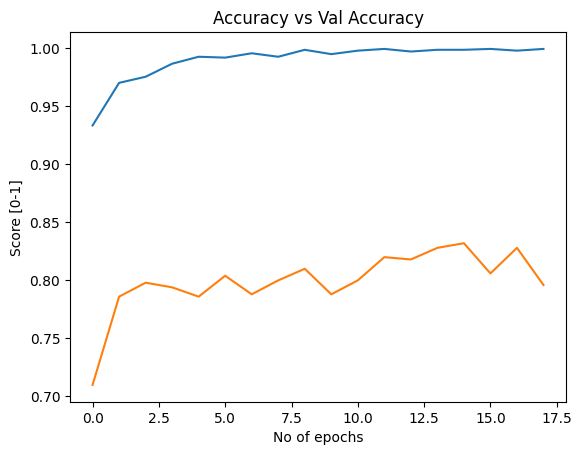

In [29]:
plt.title("Accuracy vs Val Accuracy")
plt.xlabel('No of epochs')
plt.ylabel('Score [0-1]')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

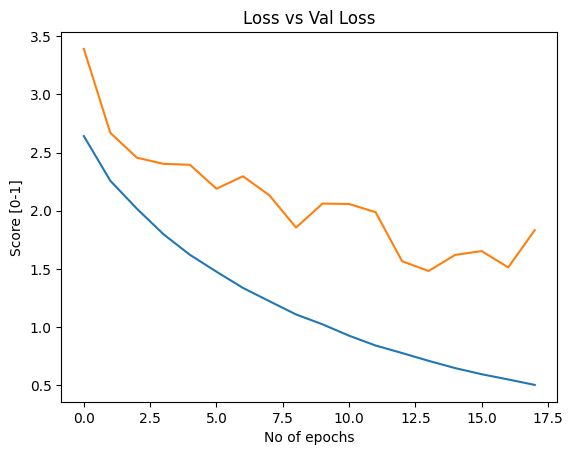

In [30]:
plt.title("Loss vs Val Loss")
plt.xlabel('No of epochs')
plt.ylabel('Score [0-1]')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

# Testing

In [7]:
test_loss, test_acc = model.evaluate(validation_ds)
print(f'Test accuracy = {test_acc}\n Test loss    = {test_loss}')

16/16 [==============================] - 5s 217ms/step - loss: 1.6197 - accuracy: 0.8317
Test accuracy = 0.8316633105278015
 Test loss    = 1.6196694374084473


In [14]:
def predict_img(img_path):
    image = cv2.imread(img_path)
    img = cv2.resize(image, (180, 180))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(img, axis=0)
    p=model.predict(img)
    if  p < 0.97:
        print("Person is not affected with Pneumonia.")
    else:
        print("Person is affected with Pneumonia.")

In [13]:
img_path = 'D:\\Users\\Desktop\\Sem V\\DL\\DL-projects\\mini project\\DL_Dataset\\test\\NORMAL\\imageresized_7.jpeg'
predict_img(img_path)

1/1 [==============================] - 0s 53ms/step
Person is not affected with Pneumonia. <class 'numpy.ndarray'>


In [24]:
img_path = 'D:\\Users\\Desktop\\Sem V\\DL\\DL-projects\\mini project\\DL_Dataset\\test\\PNEUMONIA\\imageresized_7.jpeg'
predict_img(img_path)

1/1 [==============================] - 0s 37ms/step
Person is affected with Pneumonia.
